<a href="https://colab.research.google.com/github/jfogarty/machine-learning-intro-workshop/blob/master/notebooks/Latent_Me.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Save a Copy (File -> Save a copy in Drive) to run

# Finding yourself in the latent space of StyleGAN

Dmitry Nikitko (puzer) wrote [the original code](https://github.com/Puzer/stylegan) for this notebook which extends the work released by NVidia on StyleGAN. I have modified and annotated it to make it easier to use in Colab. After running through this notebook you should have a StyleGAN generated image (or set of images) which closely match photos of you that you've uploaded.

You'll also have a `npy` file which is the latent code (or location) of your image in the StyleGAN latent space.

In [0]:
!git clone https://github.com/Puzer/stylegan

In [0]:
%cd stylegan
# Use the version this notebook was built with
!git checkout c3fb250c65840c8837ded78e34485227755c2473

In [0]:
!mkdir raw_images aligned_images generated_images latent_representations

## Add your image(s)

Upload your image using the Sidebar now. 

To open the sidebar select "View" and then "Table of Contents".

The sidebar should now be open. Click the "Files" tab.

Before uploading make sure:

1.   The image(s) you're using can be opened by PIL (jpg, png, etc)
2.   The images are larger than 1024x1024. Preferably significantly larger so the aligner can crop out a high resolution section of the image containing your face.
3.   Your face in the image is well lit and facing the camera (for best results)

Click ''Upload" in the sidebar and select the images you want to upload from your computer.

Note: All files uploaded in this manner end up in the root of the file tree. We'll move them into the correct spot next.

In [0]:
# e.g. mv ../me.jpg raw_images/
!mv ../<YOUR UPLOAD NAME> raw_images/

## Align your images

In [0]:
!python align_images.py raw_images aligned_images

This should produce an image in `aligned_images/` for every image in `raw_images/`.

It's a good idea to check that this process worked by using the Files browser to download each aligned image and make sure it looks reasonable. If you encounter scrambled images it might be because your original raw images are too small.

## Search for your latent self

The script `encode_images.py` will minimize the perceptual loss between generated images from StyleGAN and each of the images you've uploaded. (By default this happens one at a time)

I've had good results at 1000 iterations and it's best to check the general quality before coming back and ramping up the number of iterations to produce a high-quality latent.

Higher quality comes at a cost of course. 10000 iterations will take about **one hour** for one image.

**NOTE:** You may get a warning about the GPU memory limit when running this script. Don't worry it will still complete.

In [0]:
!python encode_images.py aligned_images/ generated_images/ latent_representations/ --iterations 1000

## Download Your Results

After the above cell has finished writing there should be an image in `generated_images/` for each image in `aligned_images/`.

You can right-click and download each of these images to see your final latent self.

### Latent Representation

You can also download the `npy` files in the `latent_representations/` directory. Each of those is a serialized numpy array which contains the (18, 512) array encoding the point in latent space which corresponds to the generated image. Which you can open with `latent = np.load('filename.npy')`

### Change your Smile, Gender, or Age

Once your latent representation has been generated and saved you can explore the volume around it through latent vectors. Puzer has provided vectors for Smile, Gender and Age so you can see what you look like as your latent self varies along those axes.

Run the following cells.

In [0]:
import os
import pickle
import PIL.Image
import numpy as np
import dnnlib
import dnnlib.tflib as tflib
import config
from encoder.generator_model import Generator

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
URL_FFHQ = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ'

tflib.init_tf()
with dnnlib.util.open_url(URL_FFHQ, cache_dir=config.cache_dir) as f:
    generator_network, discriminator_network, Gs_network = pickle.load(f)

generator = Generator(Gs_network, batch_size=1, randomize_noise=False)

In [0]:
def generate_image(latent_vector):
    latent_vector = latent_vector.reshape((1, 18, 512))
    generator.set_dlatents(latent_vector)
    img_array = generator.generate_images()[0]
    img = PIL.Image.fromarray(img_array, 'RGB')
    return img.resize((256, 256))

def move_and_show(latent_vector, direction, coeffs):
    fig,ax = plt.subplots(1, len(coeffs), figsize=(15, 10), dpi=80)
    for i, coeff in enumerate(coeffs):
        new_latent_vector = latent_vector.copy()
        new_latent_vector[:8] = (latent_vector + coeff*direction)[:8]
        ax[i].imshow(generate_image(new_latent_vector))
        ax[i].set_title('Coeff: %0.1f' % coeff)
    [x.axis('off') for x in ax]
    plt.show()

In [0]:
# Loading already learned representations
me = np.load('latent_representations/<YOUR FILENAME>.npy')

In [0]:
# Loading already learned latent directions
smile_direction = np.load('ffhq_dataset/latent_directions/smile.npy')
gender_direction = np.load('ffhq_dataset/latent_directions/gender.npy')
age_direction = np.load('ffhq_dataset/latent_directions/age.npy')

# In general it's possible to find directions of almost any face attributes: position, hair style or color ... 
# Additional scripts for doing so will be realised soon

# Smile transformation

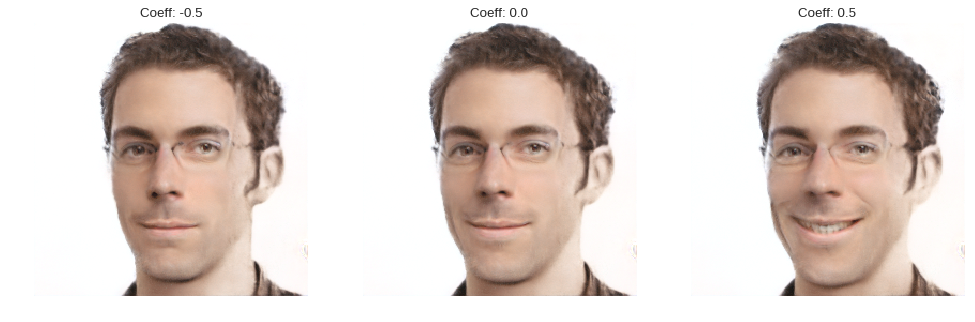

In [0]:
move_and_show(me, smile_direction, [-0.5, 0, 0.5])

# Gender transformation

In [0]:
move_and_show(me, gender_direction, [-1, 0, 1])

# Age transformation

In [0]:
move_and_show(me, age_direction, [-1, 0, 1])